# LSTM for Text Classification

## 1. Getting the Dataset

In [81]:
import keras
imdb = keras.datasets.imdb

In [82]:
# loading only the top 10000 words in the vocabulary like you did last week.
VOCAB_SIZE = 10000
# we reserve indices 0 for ‘<PAD>’, 1 for ‘<START>’ and 2 for ‘<UNK>’ i.e. words not in vocabulary
INDEX_FROM = 3 # EDITED
(train_data,train_labels),(test_data,test_labels) = imdb.load_data(num_words=VOCAB_SIZE,
index_from=INDEX_FROM)

In [83]:
print('Sample review:', train_data[0])
print('\n Sample label:', test_labels[1])

Sample review: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]

 Sample label: 1


## 2. Readying the Inputs for the LSTM

In [84]:
from keras.preprocessing.sequence import pad_sequences
MAXIMUM_LENGTH = 500

In [85]:
word_index = imdb.get_word_index()
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  
word_index["<UNUSED>"] = 3

preprocessed_train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=MAXIMUM_LENGTH)

In [86]:
print('Length of sample train_data before preprocessing:', len(train_data[0]))
print('Length of sample train_data after preprocessing:', len(preprocessed_train_data[0]))

Length of sample train_data before preprocessing: 218
Length of sample train_data after preprocessing: 500


## 3. Building the Model

In [87]:
import keras
import numpy as np
from keras.layers import LSTM, Embedding, Input, Dense, Dropout
from keras.models import Sequential
from keras.models import Model
units = 100
EMBED_SIZE = 100

input_layer = Input(shape=(MAXIMUM_LENGTH,), dtype='int32', name='input_1')
embedding = Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAXIMUM_LENGTH, name='Embedding_Layer')(input_layer)
lstm = LSTM(units, activation='tanh', recurrent_activation='sigmoid', name='LSTM_layer')(embedding)
dense = Dense(1, input_shape=(1,), activation='sigmoid', kernel_initializer='glorot_uniform', name='Output_layer')(lstm)

model = Model(inputs=[input_layer], outputs=[dense])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500)               0         
_________________________________________________________________
Embedding_Layer (Embedding)  (None, 500, 100)          1000000   
_________________________________________________________________
LSTM_layer (LSTM)            (None, 100)               80400     
_________________________________________________________________
Output_layer (Dense)         (None, 1)                 101       
Total params: 1,080,501
Trainable params: 1,080,501
Non-trainable params: 0
_________________________________________________________________


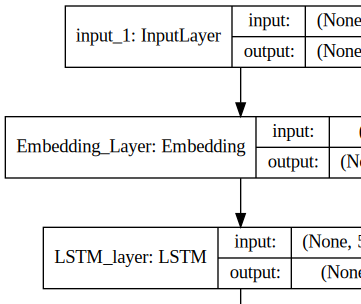

In [88]:
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

## 4. Training the Model

In [89]:
EPOCHS = 3
BATCH_SIZE = 100

x_val = np.array(preprocessed_train_data[:2000])
x_train = np.array(preprocessed_train_data[2000:])

y_val = np.array(train_labels[:2000])
y_train = np.array(train_labels[2000:])



history = model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE,
          validation_data=(x_val, y_val))

Train on 23000 samples, validate on 2000 samples
Epoch 1/3
23000/23000 [==============================] - 189s 8ms/step - loss: 0.6927 - accuracy: 0.5071 - val_loss: 0.6900 - val_accuracy: 0.5090
Epoch 2/3
23000/23000 [==============================] - 188s 8ms/step - loss: 0.6803 - accuracy: 0.5218 - val_loss: 0.6873 - val_accuracy: 0.5190
Epoch 3/3
23000/23000 [==============================] - 183s 8ms/step - loss: 0.6523 - accuracy: 0.5783 - val_loss: 0.6505 - val_accuracy: 0.6580


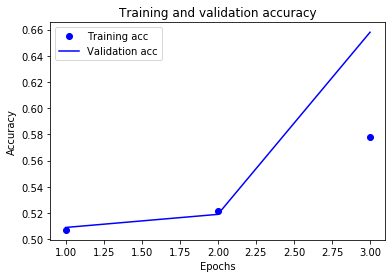

In [90]:
import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 5. Evaluating the Model on the Test Data

In [32]:

preprocessed_test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=MAXIMUM_LENGTH)
results = model.evaluate(preprocessed_test_data, test_labels)
print('test_loss:', results[0], 'test_accuracy:', results[1])

25000/25000 [==============================] - 99s 4ms/step
test_loss: 0.6952787357521057 test_accuracy: 0.51555997133255


## 6. Extracting the Word Embeddings

In [91]:
word_embeddings = model.get_layer('Embedding_Layer').get_weights()[0]

In [92]:
model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500)               0         
_________________________________________________________________
Embedding_Layer (Embedding)  (None, 500, 100)          1000000   
_________________________________________________________________
LSTM_layer (LSTM)            (None, 100)               80400     
_________________________________________________________________
Output_layer (Dense)         (None, 1)                 101       
Total params: 1,080,501
Trainable params: 1,080,501
Non-trainable params: 0
_________________________________________________________________


In [34]:
print('Shape of word_embeddings:', word_embeddings.shape)

Shape of word_embeddings: (10000, 100)


## 7. Visualizing the Reviews

In [60]:
word2idx = imdb.get_word_index()
word2idx = {k:(v+INDEX_FROM) for k,v in word2idx.items() if v < 9998}
word2idx["<PAD>"] = 0
word2idx["<START>"] = 1
word2idx["<UNK>"] = 2

idx2word = {}

for k,v in word2idx.items():
    idx2word[v] = k

In [61]:
print(' '.join(idx2word[idx] for idx in train_data[0]))

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

In [62]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


## 8. Visualizing the Word_Embeddings

In [63]:
from pandas import DataFrame
print(DataFrame(word_embeddings, index=idx2word.values()).head(10))

                 0         1         2         3         4         5   \
woods      0.024188 -0.035626  0.020033 -0.004826 -0.011097  0.041299   
hanging   -0.023686  0.039995  0.024655 -0.049787  0.003555 -0.005358   
woody      0.042992 -0.059526 -0.032346  0.012404 -0.033204  0.024899   
arranged   0.043984 -0.007139  0.039525  0.019116  0.046628 -0.018431   
bringing  -0.048412  0.019376  0.005543 -0.035169 -0.002327  0.002885   
wooden    -0.046992  0.023822 -0.062534  0.013614  0.001276 -0.058028   
errors    -0.006899  0.051744 -0.042060  0.040874 -0.004292  0.002719   
dialogs   -0.035241  0.046159 -0.052651 -0.055415 -0.024793 -0.061027   
kids       0.007404 -0.028581  0.020779 -0.033703 -0.006895  0.019340   
uplifting -0.024134 -0.048341 -0.035027 -0.000473 -0.013263 -0.012841   

                 6         7         8         9   ...        90        91  \
woods      0.004542  0.046331  0.030973  0.013837  ...  0.002725  0.013247   
hanging    0.040757  0.033478 -0.011381 

Plot the word embeddings using TSNE.

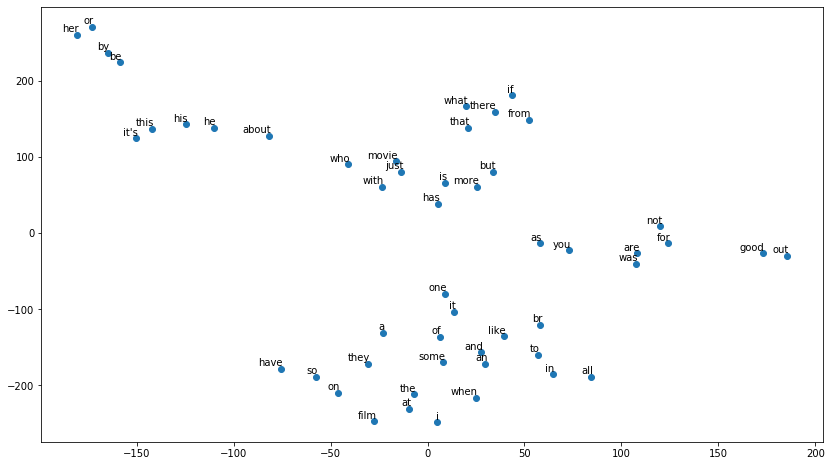

In [64]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
tsne = TSNE(perplexity=3, n_components=2, init='pca', n_iter=5000, method='exact')
np.set_printoptions(suppress=True)
start = 3
plot_only = 54
T = tsne.fit_transform(word_embeddings[start:plot_only, :])
labels = [idx2word[i+1] for i in range(start, plot_only)]
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1])
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points', ha='right',va='bottom')